# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import albumentations as A
import numpy as np
from albumentations.pytorch import ToTensorV2


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


# Dataset and Creating Train/Test Split

In [4]:
from utils import get_mnist_data
train, test = get_mnist_data()


Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model
Let's start with the model we first saw

In [6]:
import torch.nn.functional as F
dropout_value = 0.05
from model import Model_7


# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_7().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           9,216
             ReLU-10           [-1, 32, 16, 16]               0
      BatchNorm2d-11           [-1, 32, 16, 16]              64
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 32, 18, 18]           1,024
           Conv2d-14           [-1

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [8]:
# from utils import train, test



from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
from torch.optim.lr_scheduler import StepLR

model =  Model_7().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.4868037700653076 Batch_id=390 Accuracy=33.22: 100%|██████████| 391/391 [00:26<00:00, 14.76it/s]



Test set: Average loss: 1.4658, Accuracy: 4588/10000 (45.88%)

EPOCH: 1


Loss=1.3984849452972412 Batch_id=390 Accuracy=44.42: 100%|██████████| 391/391 [00:21<00:00, 18.08it/s]



Test set: Average loss: 1.2677, Accuracy: 5366/10000 (53.66%)

EPOCH: 2


Loss=1.462332010269165 Batch_id=390 Accuracy=50.73: 100%|██████████| 391/391 [00:22<00:00, 17.30it/s]



Test set: Average loss: 1.1517, Accuracy: 5859/10000 (58.59%)

EPOCH: 3


Loss=1.3837867975234985 Batch_id=390 Accuracy=55.25: 100%|██████████| 391/391 [00:25<00:00, 15.20it/s]



Test set: Average loss: 1.0855, Accuracy: 6103/10000 (61.03%)

EPOCH: 4


Loss=1.0289011001586914 Batch_id=390 Accuracy=58.01: 100%|██████████| 391/391 [00:24<00:00, 15.98it/s]



Test set: Average loss: 0.9297, Accuracy: 6645/10000 (66.45%)

EPOCH: 5


Loss=1.1621264219284058 Batch_id=390 Accuracy=60.67: 100%|██████████| 391/391 [00:22<00:00, 17.31it/s]



Test set: Average loss: 0.9158, Accuracy: 6754/10000 (67.54%)

EPOCH: 6


Loss=0.8934847116470337 Batch_id=390 Accuracy=62.28: 100%|██████████| 391/391 [00:23<00:00, 16.81it/s]



Test set: Average loss: 0.8587, Accuracy: 6930/10000 (69.30%)

EPOCH: 7


Loss=0.9958353042602539 Batch_id=390 Accuracy=63.97: 100%|██████████| 391/391 [00:21<00:00, 18.41it/s]



Test set: Average loss: 0.7849, Accuracy: 7249/10000 (72.49%)

EPOCH: 8


Loss=0.7722654342651367 Batch_id=390 Accuracy=65.44: 100%|██████████| 391/391 [00:21<00:00, 17.94it/s]



Test set: Average loss: 0.7899, Accuracy: 7263/10000 (72.63%)

EPOCH: 9


Loss=0.8733459711074829 Batch_id=390 Accuracy=66.77: 100%|██████████| 391/391 [00:22<00:00, 17.24it/s]



Test set: Average loss: 0.7359, Accuracy: 7374/10000 (73.74%)

EPOCH: 10


Loss=0.7417923212051392 Batch_id=390 Accuracy=67.77: 100%|██████████| 391/391 [00:22<00:00, 17.35it/s]



Test set: Average loss: 0.7201, Accuracy: 7549/10000 (75.49%)

EPOCH: 11


Loss=0.89312744140625 Batch_id=390 Accuracy=68.69: 100%|██████████| 391/391 [00:21<00:00, 18.61it/s]



Test set: Average loss: 0.6918, Accuracy: 7591/10000 (75.91%)

EPOCH: 12


Loss=0.7438483834266663 Batch_id=390 Accuracy=69.00: 100%|██████████| 391/391 [00:21<00:00, 18.53it/s]



Test set: Average loss: 0.6768, Accuracy: 7628/10000 (76.28%)

EPOCH: 13


Loss=0.8915961384773254 Batch_id=390 Accuracy=70.19: 100%|██████████| 391/391 [00:22<00:00, 17.13it/s]



Test set: Average loss: 0.7006, Accuracy: 7593/10000 (75.93%)

EPOCH: 14


Loss=0.7645997405052185 Batch_id=390 Accuracy=70.81: 100%|██████████| 391/391 [00:22<00:00, 17.29it/s]



Test set: Average loss: 0.6352, Accuracy: 7857/10000 (78.57%)

EPOCH: 15


Loss=0.6678868532180786 Batch_id=390 Accuracy=71.13: 100%|██████████| 391/391 [00:22<00:00, 17.28it/s]



Test set: Average loss: 0.5951, Accuracy: 7910/10000 (79.10%)

EPOCH: 16


Loss=0.8166211843490601 Batch_id=390 Accuracy=71.86: 100%|██████████| 391/391 [00:22<00:00, 17.44it/s]



Test set: Average loss: 0.5996, Accuracy: 7949/10000 (79.49%)

EPOCH: 17


Loss=0.7641319036483765 Batch_id=390 Accuracy=72.07: 100%|██████████| 391/391 [00:21<00:00, 18.37it/s]



Test set: Average loss: 0.6396, Accuracy: 7801/10000 (78.01%)

EPOCH: 18


Loss=0.8058390617370605 Batch_id=390 Accuracy=72.71: 100%|██████████| 391/391 [00:21<00:00, 18.40it/s]



Test set: Average loss: 0.6388, Accuracy: 7829/10000 (78.29%)

EPOCH: 19


Loss=0.5904462337493896 Batch_id=390 Accuracy=72.82: 100%|██████████| 391/391 [00:22<00:00, 17.23it/s]



Test set: Average loss: 0.5743, Accuracy: 8031/10000 (80.31%)



In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.08, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.8889191746711731 Batch_id=390 Accuracy=73.98: 100%|██████████| 391/391 [00:22<00:00, 17.47it/s]



Test set: Average loss: 0.5492, Accuracy: 8110/10000 (81.10%)

EPOCH: 1


Loss=0.7656761407852173 Batch_id=390 Accuracy=74.55: 100%|██████████| 391/391 [00:21<00:00, 18.06it/s]



Test set: Average loss: 0.5577, Accuracy: 8081/10000 (80.81%)

EPOCH: 2


Loss=0.6481217741966248 Batch_id=390 Accuracy=74.85: 100%|██████████| 391/391 [00:20<00:00, 18.71it/s]



Test set: Average loss: 0.5460, Accuracy: 8072/10000 (80.72%)

EPOCH: 3


Loss=0.8162250518798828 Batch_id=390 Accuracy=75.28: 100%|██████████| 391/391 [00:21<00:00, 17.93it/s]



Test set: Average loss: 0.5295, Accuracy: 8172/10000 (81.72%)

EPOCH: 4


Loss=0.7989577054977417 Batch_id=390 Accuracy=75.03: 100%|██████████| 391/391 [00:22<00:00, 17.17it/s]



Test set: Average loss: 0.5319, Accuracy: 8194/10000 (81.94%)

EPOCH: 5


Loss=0.8968096971511841 Batch_id=390 Accuracy=75.36: 100%|██████████| 391/391 [00:24<00:00, 16.27it/s]



Test set: Average loss: 0.5219, Accuracy: 8197/10000 (81.97%)

EPOCH: 6


Loss=0.7219406366348267 Batch_id=390 Accuracy=75.82: 100%|██████████| 391/391 [00:21<00:00, 18.35it/s]



Test set: Average loss: 0.5169, Accuracy: 8240/10000 (82.40%)

EPOCH: 7


Loss=0.6718244552612305 Batch_id=390 Accuracy=75.83: 100%|██████████| 391/391 [00:20<00:00, 18.75it/s]



Test set: Average loss: 0.4925, Accuracy: 8313/10000 (83.13%)

EPOCH: 8


Loss=0.754736065864563 Batch_id=390 Accuracy=75.95: 100%|██████████| 391/391 [00:24<00:00, 16.15it/s]



Test set: Average loss: 0.5290, Accuracy: 8205/10000 (82.05%)

EPOCH: 9


Loss=0.6368741393089294 Batch_id=390 Accuracy=76.10: 100%|██████████| 391/391 [00:22<00:00, 17.58it/s]



Test set: Average loss: 0.4982, Accuracy: 8302/10000 (83.02%)



In [11]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.718144953250885 Batch_id=390 Accuracy=78.65: 100%|██████████| 391/391 [00:22<00:00, 17.18it/s]



Test set: Average loss: 0.4633, Accuracy: 8433/10000 (84.33%)

EPOCH: 1


Loss=0.5795814394950867 Batch_id=390 Accuracy=78.67: 100%|██████████| 391/391 [00:24<00:00, 16.24it/s]



Test set: Average loss: 0.4464, Accuracy: 8470/10000 (84.70%)

EPOCH: 2


Loss=0.5722944736480713 Batch_id=390 Accuracy=79.13: 100%|██████████| 391/391 [00:20<00:00, 18.63it/s]



Test set: Average loss: 0.4487, Accuracy: 8447/10000 (84.47%)

EPOCH: 3


Loss=0.731995165348053 Batch_id=390 Accuracy=79.15: 100%|██████████| 391/391 [00:21<00:00, 18.38it/s]



Test set: Average loss: 0.4454, Accuracy: 8492/10000 (84.92%)

EPOCH: 4


Loss=0.5808884501457214 Batch_id=390 Accuracy=79.52: 100%|██████████| 391/391 [00:21<00:00, 17.95it/s]



Test set: Average loss: 0.4448, Accuracy: 8525/10000 (85.25%)

EPOCH: 5


Loss=0.5746455192565918 Batch_id=390 Accuracy=79.37: 100%|██████████| 391/391 [00:22<00:00, 17.54it/s]



Test set: Average loss: 0.4403, Accuracy: 8540/10000 (85.40%)

EPOCH: 6


Loss=0.627721905708313 Batch_id=390 Accuracy=79.58: 100%|██████████| 391/391 [00:22<00:00, 17.77it/s]



Test set: Average loss: 0.4424, Accuracy: 8506/10000 (85.06%)

EPOCH: 7


Loss=0.44671911001205444 Batch_id=390 Accuracy=79.50: 100%|██████████| 391/391 [00:23<00:00, 16.90it/s]



Test set: Average loss: 0.4404, Accuracy: 8522/10000 (85.22%)

EPOCH: 8


Loss=0.7215706706047058 Batch_id=390 Accuracy=79.54: 100%|██████████| 391/391 [00:20<00:00, 18.83it/s]



Test set: Average loss: 0.4382, Accuracy: 8506/10000 (85.06%)

EPOCH: 9


Loss=0.6044947504997253 Batch_id=390 Accuracy=79.66: 100%|██████████| 391/391 [00:21<00:00, 17.81it/s]



Test set: Average loss: 0.4423, Accuracy: 8513/10000 (85.13%)



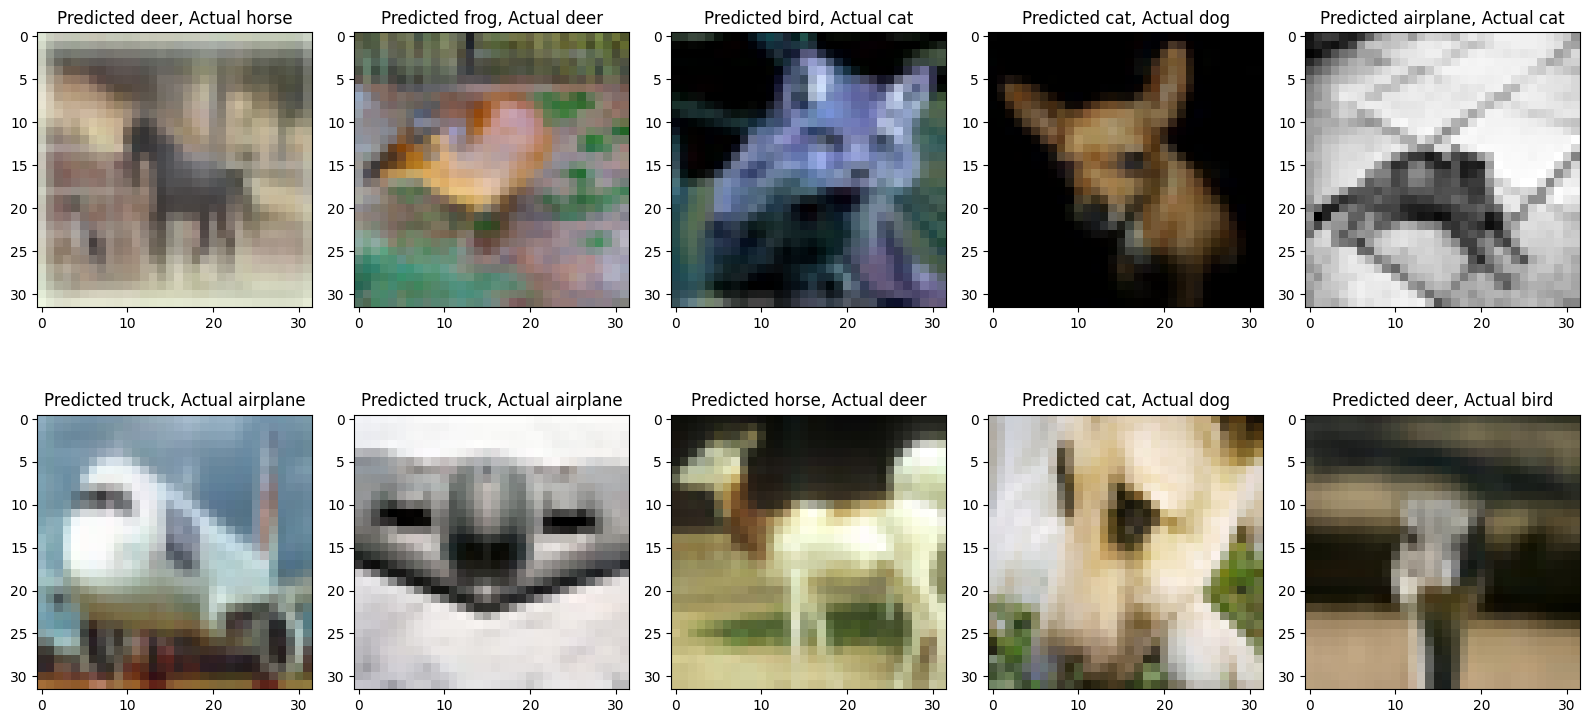

In [12]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def get_incorrect_images(model,test_loader,n=10):
  incorrect_images = []
  predicted_labels = []
  correct_labels = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    incorrect_items = pred.ne(target.view_as(pred))
    incorrect_indices = incorrect_items.view(-1).nonzero().view(-1)
    predicted_labels.extend([item.item() for item in pred[incorrect_indices[:n-len(incorrect_images)]]])
    correct_labels.extend([item.item() for item in target.view_as(pred)[incorrect_indices[:n-len(incorrect_images)]]])
    incorrect_images.extend([item for item in data[incorrect_indices[:n-len(incorrect_images)]]])
    if len(incorrect_images)==n:
      break
  return incorrect_images,predicted_labels,correct_labels

def imshow(img):
  img = img / 2 + 0.5     # Unnormalize
  npimg = img
  npimg = np.clip(npimg, 0, 1)  # Add this line to clip the values
  return np.transpose(npimg, (1, 2, 0))  # Convert from Tensor image

fig, axes = plt.subplots(2, 5, figsize=(16, 8))

incorrect_images,predicted_labels,correct_labels = get_incorrect_images(model,test_loader,n=10)

for i, image_tensor in enumerate(incorrect_images):
    ax = axes[i // 5, i % 5]  # Get the location of the subplot
    image = image_tensor.cpu().numpy()
    ax.imshow(imshow(image))  # Display the image
    ax.set_title(f"Predicted {class_names[predicted_labels[i]]}, Actual {class_names[correct_labels[i]]}")  # Set the title as the index

plt.tight_layout()  # To provide sufficient spacing between subplots
plt.show()